<h1 class="text-center">NeuroIA - Introduction to statistics for experimentation - 12/03/2019</h1>

<br>

<div class="jumbotron text-center"><b>The purpose of this tutorial is to learn how to infer statistically significant results from data.</b></div>

Import the following libraries and functions.

In [513]:
# This action is to be done once at the beginning of the tutorial
%matplotlib inline
import numpy as np
from numpy import genfromtxt
import pandas as pd
import scipy
from scipy import stats
from scipy.stats import binom, norm, t
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import scale

In [43]:
mplt_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

<br>
<a id="1BIT"></a><h1>I. Overview </h1>

<div class="bg-danger" style="padding:1em"><b>Definition:</b> RR data (or Inter-Beat Intervals, IBI) is the duration between two pulsations in an electrocardiography.</div>



First, we wish to pre-process data from electrocardiography equipment.
Load the file "FarosRR.csv" which contains this physiological data.

In [2]:
# load heart rate data
rr_data = genfromtxt('FarosRR.csv', delimiter=',')
print(rr_data)

[[   648.76 -31874.  ]
 [   649.57 -31912.  ]
 [   650.35 -31894.  ]
 ...
 [  3952.1  -31656.  ]
 [  3953.1  -31723.  ]
 [  3954.1  -31840.  ]]


<p class="bg-primary" style="padding:1em">**QUESTION** The data recording is shifted by $-2^{15}$. Fill in the code below to get the correct values in milliseconds.</p>.

In [3]:
rr_data[:,1]+= 2**15# fill the code
print(rr_data)

[[ 648.76  894.  ]
 [ 649.57  856.  ]
 [ 650.35  874.  ]
 ...
 [3952.1  1112.  ]
 [3953.1  1045.  ]
 [3954.1   928.  ]]


<p class="bg-primary" style="padding:1em"> Creation of qualitative variables. Load the file "rests.csv" which contains the times of the rest sessions.</p>

In [4]:
# load times of the rest sessions
rests_data = genfromtxt('rests.csv', delimiter=',')
print(rests_data)

[[ 678.65  738.66]
 [1506.3  1566.3 ]
 [2296.7  2356.7 ]
 [3094.7  3154.7 ]]


In [156]:
df = pd.DataFrame(rr_data, columns=["timestamp", "delta_t"])
df.head(2)

,timestamp,delta_t
0,648.76,894.0
1,649.57,856.0


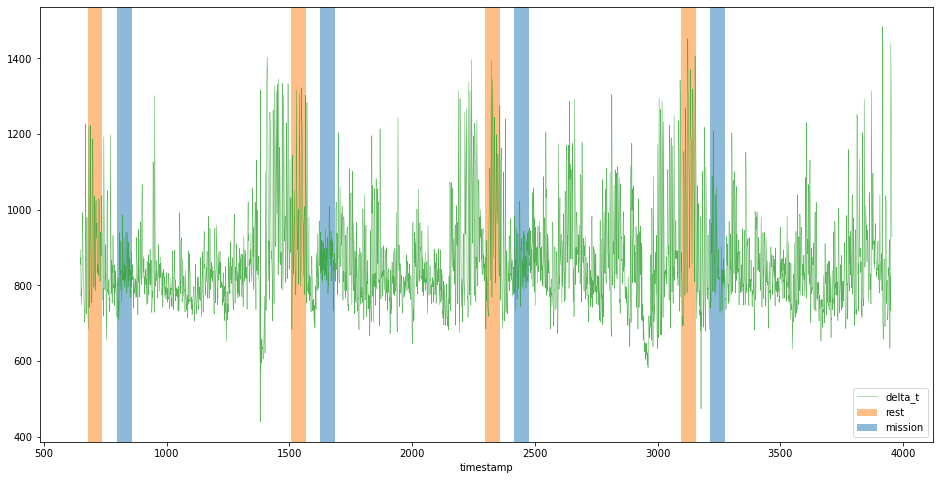

In [157]:
fig, ax = plt.subplots(figsize=(16,8))
df.plot(x="timestamp", y="delta_t", ax=ax, alpha=0.8, linewidth=0.5, color=mplt_colors[2])
for i, rest_interval in enumerate(rests_data):
    ax.axvspan(*rest_interval, facecolor=mplt_colors[1] ,alpha=0.5, label="_"*i + "rest")
    ax.axvspan(rest_interval[1]+60, rest_interval[1]+2*60, facecolor=mplt_colors[0] ,alpha=0.5, label="_"*i + "mission")
    
ax.legend()

In [175]:
def rest_session(timestamp):
    for i in range(len(rests_data)):
        if rests_data[i][0] <= timestamp and timestamp <= rests_data[i][1]:
            return str(i)+"_rest_"+str(i)
#         if rests_data[i][1] < timestamp and (i<len(rests_data)-1 and timestamp <= rests_data[i+1][0] or i==len(rests_data)-1):
        if rests_data[i][1]+60 < timestamp and timestamp <= rests_data[i][1] + 2*60:
            return str(i)+"_effort_"+str(i)
    return "transition"
    
def session_type(session):
    if "rest" in session:
        return "rest"
    if "effort" in session:
        return "mission"
    return "transition"
    
    
df["session"] = df.apply (lambda row: rest_session(row.timestamp), axis=1)
df["type"] = df.apply (lambda row: session_type(row.session), axis=1)
pd.concat([df.iloc[34:38],df.iloc[101:104],df.iloc[174:178],df.iloc[246:250]])

,timestamp,delta_t,session,type
34,677.16,903.0,transition,transition
35,677.97,823.0,transition,transition
36,678.77,808.0,0_rest_0,rest
37,679.61,763.0,0_rest_0,rest
101,737.58,940.0,0_rest_0,rest
102,738.61,935.0,0_rest_0,rest
103,739.63,923.0,transition,transition
174,798.01,716.0,transition,transition
175,798.60,716.0,transition,transition
176,799.41,750.0,0_effort_0,mission


In [176]:
df["session"].unique(), df["type"].unique()

(array(['transition', '0_rest_0', '0_effort_0', '1_rest_1', '1_effort_1',
        '2_rest_2', '2_effort_2', '3_rest_3', '3_effort_3'], dtype=object),
 array(['transition', 'rest', 'mission'], dtype=object))

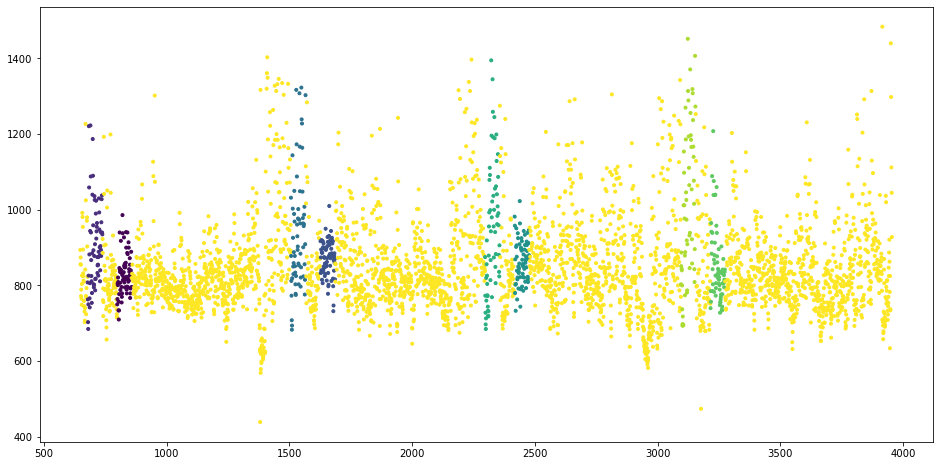

In [177]:
def df_scatter(df, xcol='timestamp', ycol='delta_t', catcol='session'):
    fig, ax = plt.subplots(figsize=(16,8))
    categories = np.unique(df[catcol])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))  

    colors = df[catcol].apply(lambda x: colordict[x])
    ax.scatter(df[xcol], df[ycol], c=colors, marker='.')
    plt.show()

df_scatter(df)

Text(0.5, 1.0, "RR interval during 'rest' and 'mission' phase (measured by Faros)")

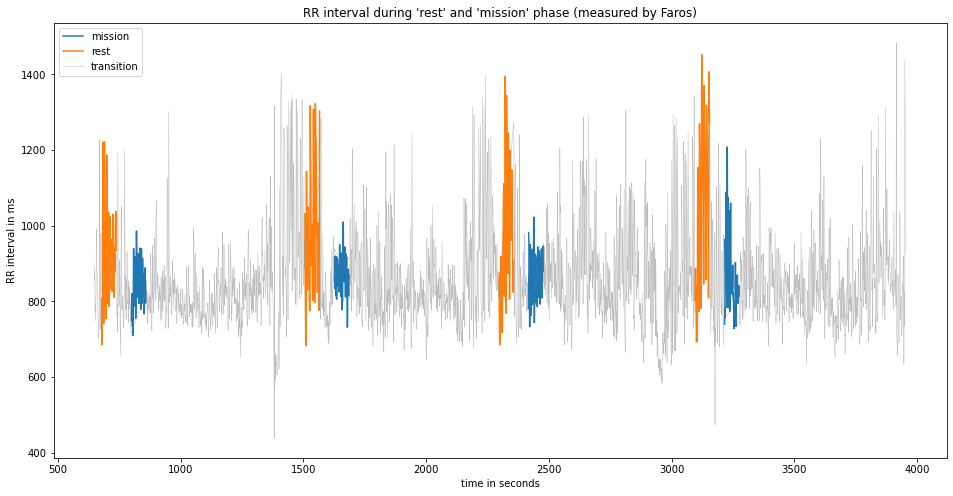

In [178]:
fig, ax = plt.subplots(figsize=(16,8))
for label, subdf in df.groupby('session'):
    if "rest" in label:
        ax.plot(subdf.timestamp, subdf.delta_t, color=mplt_colors[1], label= int(label[-1:])*"_"+"rest")
    elif "effort" in label:
        ax.plot(subdf.timestamp, subdf.delta_t, color=mplt_colors[0], label= int(label[-1:])*"_"+"mission")
    else:
        ax.plot(subdf.timestamp, subdf.delta_t, alpha=0.5, linewidth=0.5, label="transition", color=mplt_colors[7])
ax.legend()
ax.set_xlabel("time in seconds")
ax.set_ylabel("RR interval in ms")
ax.set_title("RR interval during 'rest' and 'mission' phase (measured by Faros)")

<p class="bg-primary" style="padding:1em"> Selects the RR data that correspond to the first rest session.</p>

In [222]:
isRest = np.array([rests_data[0,0]<rr_data[:,0],rests_data[0,1]>rr_data[:,0]])
isRest = isRest.all(axis=0)
rest_data = rr_data[isRest,1]
print(rest_data)

[ 808.  763.  703.  685.  750.  826. 1221. 1059.  882.  766.  742.  806.
  944. 1223. 1088.  940.  867.  825.  811.  754.  780.  885. 1040. 1187.
 1090.  959.  893.  803.  795.  802.  878. 1036. 1026.  909.  787.  817.
  818.  990. 1024.  924.  943.  955.  965.  875.  833.  853.  854.  855.
  826.  875.  889. 1030.  993.  948.  901.  880.  811.  840.  904.  941.
  894.  878.  967. 1028. 1038.  940.  935.]


<p class="bg-primary" style="padding:1em"> Selects RR data for an interval of 60 seconds after one minute of mission.</p>

In [223]:
isMission = np.array([rests_data[0,1]+60<rr_data[:,0],rests_data[0,1]+2*60>rr_data[:,0]])
isMission = isMission.all(axis=0)
mission_data = rr_data[isMission,1]
print(mission_data)

[750. 764. 805. 801. 821. 809. 734. 757. 710. 734. 777. 846. 940. 842.
 836. 807. 788. 841. 918. 834. 840. 796. 755. 770. 779. 828. 986. 938.
 814. 833. 814. 822. 835. 927. 852. 808. 848. 857. 795. 848. 852. 817.
 860. 941. 900. 823. 789. 779. 797. 886. 940. 883. 817. 795. 810. 914.
 900. 813. 843. 836. 826. 872. 855. 767. 779. 792. 840. 828. 889. 833.
 796. 825.]


<p class="bg-primary" style="padding:1em">**QUESTION** Compute the average of these values.</p>

In [181]:
mean_rest = rest_data.mean()# fill the code
mean_mission = mission_data.mean()# fill the code
print(f'mean of rest session = {mean_rest:.2f} ms')
print(f'mean of mission session = {mean_mission:.2f} ms')

mean of rest session = 903.84 ms
mean of mission session = 829.94 ms


<p class="bg-primary" style="padding:1em">**QUESTION** Compute the standard deviation these values.</p>

In [182]:
std_rest = rest_data.std()# fill the code
std_mission = mission_data.std()# fill the code
print(f'std of rest session = {std_rest:.2f} ms')
print(f'std of mission session = {std_mission:.2f} ms')

std of rest session = 114.73 ms
std of mission session = 54.11 ms


In [183]:
df.groupby("session")[["delta_t"]].describe()

delta_t                                                          \
             count         mean         std    min     25%    50%      75%   
session                                                                      
0_effort_0    72.0   829.944444   54.485530  710.0  795.75  825.5   852.00   
0_rest_0      67.0   903.835821  115.599308  685.0  817.50  885.0   962.00   
1_effort_1    69.0   869.304348   48.677300  732.0  839.00  874.0   904.00   
1_rest_1      64.0   944.750000  156.570487  683.0  828.75  906.0  1004.25   
2_effort_2    69.0   863.666667   59.344871  733.0  821.00  860.0   907.00   
2_rest_2      63.0   942.746032  170.649515  685.0  810.00  941.0  1048.50   
3_effort_3    70.0   850.600000   95.796039  728.0  790.00  828.5   879.25   
3_rest_3      59.0  1004.949153  208.880466  694.0  843.50  977.0  1176.00   
transition  3359.0   841.541828  116.219681  439.0  770.00  820.0   886.50   

                    
               max  
session             
0_effort_0   986.0  
0_rest_0    1223.0  
1_effort_1  1010.0  
1_rest_1    1323.0  
2_effort_2  1023.0  
2_rest_2    1395.0  
3_effort_3  1208.0  
3_rest_3    1452.0  
transition  1484.0

In [184]:
df.loc[df["type"].isin(["rest", "mission"])].groupby("type")[["delta_t"]].describe()

delta_t                                                              
          count        mean         std    min    25%    50%      75%     max
type                                                                         
mission   280.0  853.117857   68.508250  710.0  808.0  842.5   895.25  1208.0
rest      253.0  947.454545  167.697559  683.0  824.0  909.0  1038.00  1452.0

<p class="bg-primary" style="padding:1em"> Plot the boxplots of these samples.</p>

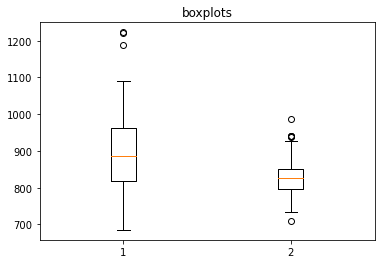

In [186]:
plt.boxplot([rest_data,mission_data]) 
plt.title("boxplots") 
plt.show()

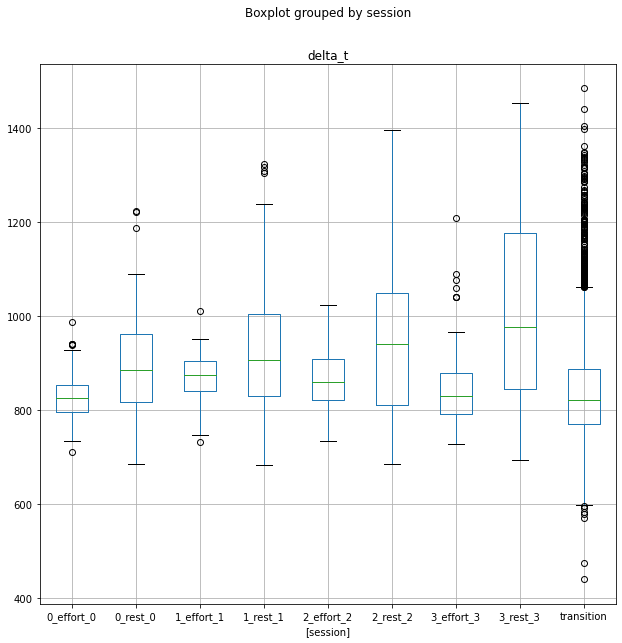

In [187]:
df[["session", "delta_t"]].boxplot(by="session",figsize=(10,10))

mission         AxesSubplot(0.1,0.15;0.363636x0.75)
rest       AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

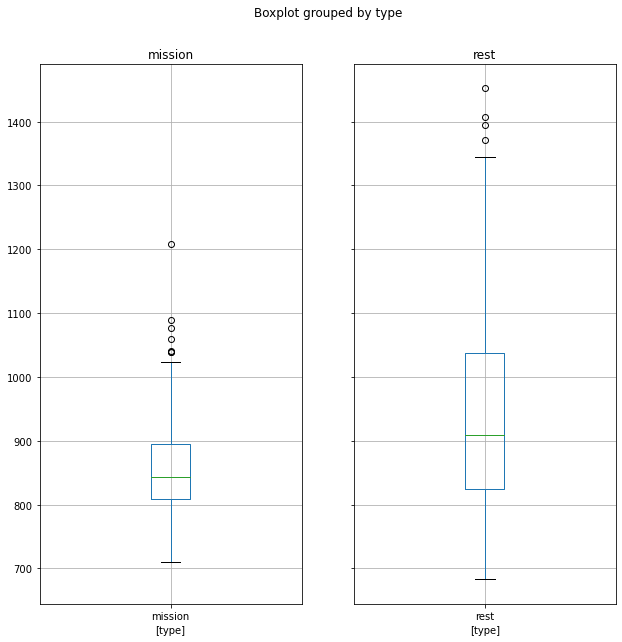

In [188]:
df.loc[df["type"].isin(["rest", "mission"])][["type","delta_t"]].groupby("type").boxplot(by="type",figsize=(10,10))

<p class="bg-primary" style="padding:1em"> Plot the histograms of these samples.</p>

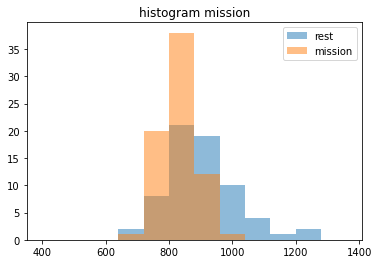

In [189]:
xmin = 400
xmax = 1400
size = 80
plt.hist(rest_data,bins=range(xmin,xmax,size),label='rest',alpha=0.5)
plt.hist(mission_data,bins=range(xmin,xmax,size),label='mission',alpha=0.5)
plt.legend(loc='upper right')
plt.title("histogram mission") 
plt.show()

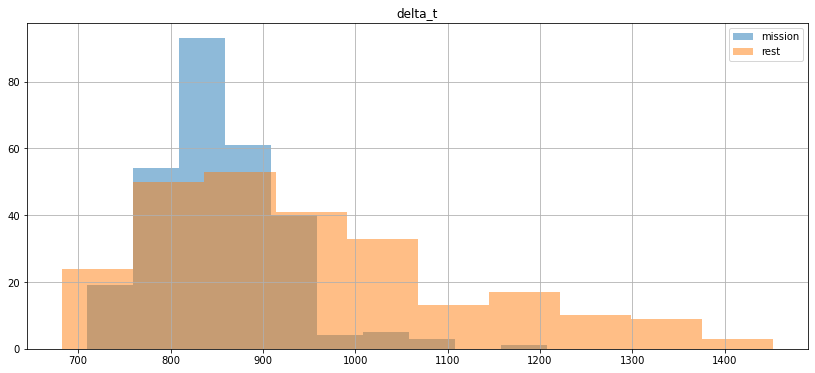

In [190]:
fig, ax = plt.subplots(figsize=(14,6))
df.loc[df["type"].isin(["rest", "mission"])][["type","delta_t"]].groupby("type").hist(ax=ax, alpha=0.5)
ax.legend(['mission', 'rest'])

<p class="bg-primary" style="padding:1em">**QUESTION** Plot the kernel density estimates of these samples using scipy.stats.gaussian_kde.</p>

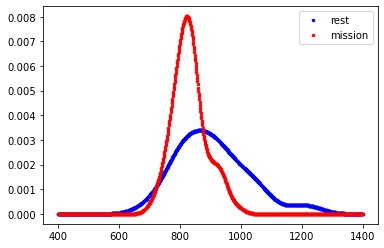

In [191]:
density_rest = scipy.stats.gaussian_kde(rest_data) # fill the code
density_mission = scipy.stats.gaussian_kde(mission_data) # fill the code
x = range(xmin,xmax,1)
y_rest = density_rest(x)
y_mission = density_mission(x)
plt.plot(x, y_rest, 'k.', markersize=5,color='blue',label='rest')
plt.plot(x, y_mission, 'k.', markersize=5,color='red',label='mission')
plt.legend(loc='upper right')
plt.show()

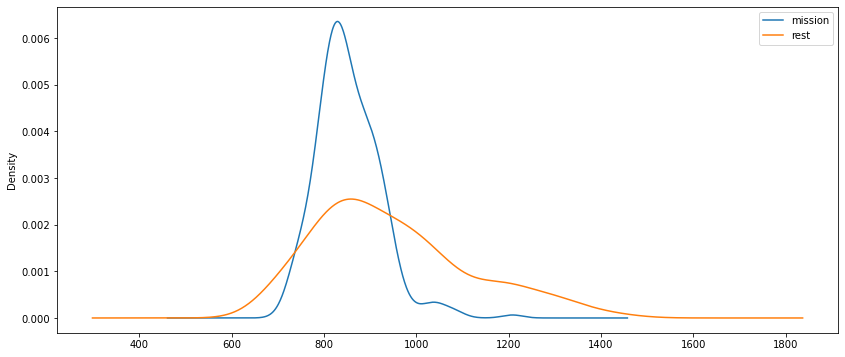

In [192]:
fig, ax = plt.subplots(figsize=(14,6))
df.loc[df["type"].isin(["rest", "mission"])][["type","delta_t"]].groupby("type").plot.kde(ax=ax)
ax.legend(['mission', 'rest'])

<p class="bg-primary" style="padding:1em">**QUESTION** Plot the kernel density estimates of normal data and the real density of a normal distribution.</p>

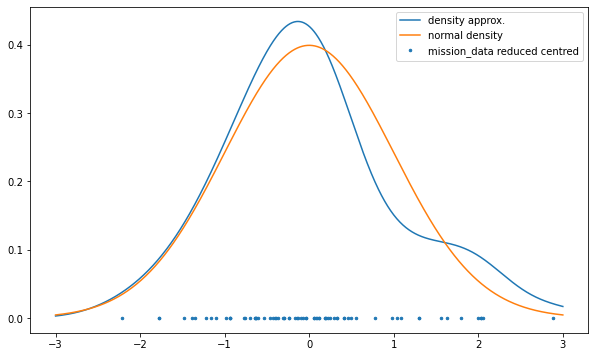

In [512]:
mission_data_norm = scale(mission_data.reshape(-1, 1)).flatten()
density_mission = scipy.stats.gaussian_kde(mission_data_norm)

Xsize = 50
# normal data simulation
X = np.random.normal(size=Xsize)
# approximation computation
approx_density = density_mission #fill the code
x = np.linspace(-3,3,1000)
y = approx_density(x)

# plot approx
plt.figure(figsize=(10,6))
plt.plot(x, y, label='density approx.')
# plot real density
y_true = norm.pdf(x)
plt.plot(x, y_true, label='normal density')
# plot simulated data
# plt.plot(X,len(X)*[0.0],'k.', markersize=5,color='red', label="np.random.normal")
plt.plot(mission_data_norm,len(mission_data_norm)*[0.0],'k.', markersize=5,color=mplt_colors[0], label="mission_data reduced centred")
plt.legend(loc='upper right')
plt.show()

<div class="bg-danger" style="padding:1em"> 
    Let $n_1$ (resp. $n_2$) be the size of rest_data (resp. mission_data).
</div> 
<div class="bg-danger" style="padding:1em"> 
    $\bullet \mu_{mission} = \frac{1}{n_1} \displaystyle \sum_{i=1}^{n_1} mission\_data(i)$,
</div>
<div class="bg-danger" style="padding:1em">
    $\bullet \displaystyle \mu_{rest} = \frac{1}{n_2}  \sum_{i=1}^{n_2} rest\_data(i)$
</div>
<div class="bg-danger" style="padding:1em">
    $\bullet \displaystyle \widehat{\sigma_M} = \sqrt{ \frac{(n_1-1)v_1 + (n_2-1)v_2}{n_1 + n_2 - 2} }$,
</div>
<div class="bg-danger" style="padding:1em">  
    with $\displaystyle v_1 = \frac{1}{n-1} \sum_{j=1}^n (mission\_data(i) - \mu_{mission})^2 $ 
    and $\displaystyle v_2 = \frac{1}{n-1} \sum_{j=1}^n (rest\_data(j) - \mu_{mission})^2 $.
</div>

<p class="bg-primary" style="padding:1em">The function $S = \dfrac{(\mu_{rest} - \mu_{mission})}{\widehat{\sigma_M} \sqrt{\frac{1}{n_1} + \frac{1}{n_2}} } \sim Student(n_1 + n_2 -2)$
  i.e. follows a Student law with parameter (degree of freedom) $n_1+n_2-2$. It allows to define the rejection region (in red) of the test $H_0:$ "means are equals" against $H_1:$ "means are different" with significance level $\alpha=0.05$.</p>

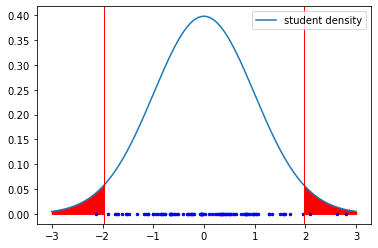

In [199]:
x = np.linspace(-3,3,1000)
n1 = len(rest_data)
n2 = len(mission_data)
# real density
y_true = scipy.stats.t.pdf(x,n1+n2-2)
# student data simulation
Xsize = 100
X = scipy.stats.t.rvs(n1+n2-2, size=Xsize)
# 2.5% left & right
x1 = scipy.stats.t.ppf(0.025,n1+n2-2)
x2 = scipy.stats.t.ppf(0.975,n1+n2-2)
## PLOT
# real density
plt.plot(x, y_true, label='student density')
# data 
plt.plot(X,len(X)*[0.0],'k.', markersize=5,color='blue')
# symetric 5% risk: only 5% of data is in the red area
plt.axvline(linewidth=1, color='r', x=x1)
plt.axvline(linewidth=1, color='r', x=x2)
xbeg = np.linspace(-3,x1,1000)
xend = np.linspace(x2,3,1000)
plt.fill_between(xbeg,scipy.stats.t.pdf(xbeg,n1+n2-2),color="r")
plt.fill_between(xend,scipy.stats.t.pdf(xend,n1+n2-2),color="r")
# legend & show
plt.legend(loc='upper right')
plt.show()

<p class="bg-primary" style="padding:1em">**QUESTION** Implement Student's test on means using scipy.stats.t.cdf .</p>

In [515]:
mission_data_norm = scale(mission_data.reshape(-1, 1)).flatten()
rest_data_norm = scale(rest_data.reshape(-1, 1)).flatten()

Value of the statistic, t_statistic=4.87
p_value=2.98e-06

p_value<alpha ? 2.98e-06 < 0.05 => True
We can assume that means are different with a risk of 5.0%

Cross Checking with 'scipy.stats.ttest_ind': 
t_statistic2=4.87 
p_value2=2.98e-06


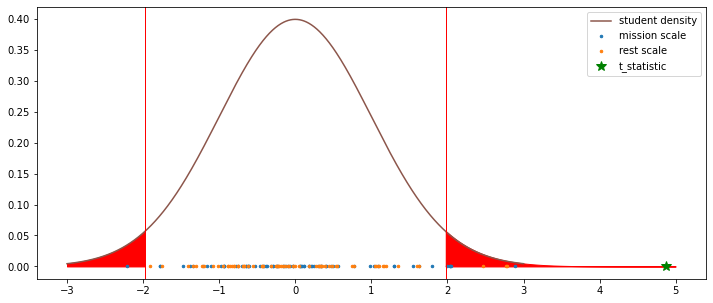

In [526]:
# STUDENT's TEST
alpha = 0.05 #Or whatever you want your alpha to be.
n1 = len(rest_data)
n2 = len(mission_data)
df = n1+n2-2

## Compute t_statstic and p_value
v1 = np.var(rest_data, ddof=1)
v2 = np.var(mission_data, ddof=1)
sigm = np.sqrt( ((n1-1)*v1 + (n2-1)*v2)/df )
denom = sigm * np.sqrt(1/n1 + 1/n2)
t_statistic = (np.mean(rest_data) - np.mean(mission_data))/denom
print(f'Value of the statistic, {t_statistic=:.2f}')
p_value = 2*(1 - stats.t.cdf(t_statistic,df=df)) # fill code
# p_value = 2*stats.t.sf(t,df=df) # also work
print(f"{p_value=:.2e}\n")

## Conclude on p_value
print(f"p_value<alpha ? {p_value:.2e} < {alpha} => {p_value<alpha}")
if (p_value < alpha):
    print(f'We can assume that means are different with a risk of {alpha*100}%')
else:
    print("We can't assume that means are different")

## Cross Checking with the internal scipy function
t_statistic2, p_value2 = stats.ttest_ind(rest_data,mission_data,equal_var=True)
print(f"\nCross Checking with 'scipy.stats.ttest_ind': \n{t_statistic2=:.2f} \n{p_value2=:.2e}")

# PLOT
plt.figure(figsize=(12,5))
plt.plot(x, y_true, label='student density', color=mplt_colors[5])
plt.plot(mission_data_norm,len(mission_data)*[0.0],'.', markersize=5, label='mission scale')
plt.plot(rest_data_norm,len(rest_data)*[0.0], '.', markersize=5, label='rest scale')
plt.plot(U,0,'*', markersize=10, color='green', label='t_statistic')
# plot rejection 2.5% left & right
x1 = scipy.stats.t.ppf(0.025,df)
x2 = scipy.stats.t.ppf(0.975,df)
# symetric 5% risk: only 5% of data is in the red area
plt.axvline(linewidth=1, color='r', x=x1)
plt.axvline(linewidth=1, color='r', x=x2)
xbeg = np.linspace(-3,x1,1000)
xend = np.linspace(x2,5,1000)
plt.fill_between(xbeg,scipy.stats.t.pdf(xbeg,df),color="r")
plt.fill_between(xend,scipy.stats.t.pdf(xend,df),color="r")
plt.legend(loc='upper right')
plt.show()

<p class="bg-primary" style="padding:1em"> Conclusion: We know how to preprocess and describe physiological data, as well as how to apply tests on data.</p>

<br>
<a id="1BIT"></a><h1>II. General Linear Model </h1>

<div class="bg-danger" style="padding:1em"><b> 1:</b> Generate two datasets distributed as the General Linear Model with the ANOVA configuration and with 3 conditions: the first one under $H_0$, the other one under $H_1$. </div>
<div class="bg-danger" style="padding:1em"><b> 2:</b> Compute the statistic in both cases.</div>
<div class="bg-danger" style="padding:1em"><b> 3:</b> Compute the p-values.</div>
<div class="bg-danger" style="padding:1em"><b> 4:</b> Compare the statistics and the p-values with the output of the scipy function for ANOVA.</div>
<div class="bg-danger" style="padding:1em"><b> *5*:</b> Same questions with the linear regression. </div>

In [16]:
# number of samples
n=1200
# number of conditions
d=3
# number of sample per condition
ni = n/d
# dataset 1
Y1 =
# dataset 2
Y2 =


SyntaxError: invalid syntax (<ipython-input-16-228c3f307e25>, line 8)